# **Face Expression Recognition Using DenseNet**

**Install Libraries**

In [2]:
!pip install timm


   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 43.8 MB/s eta 0:00:00


**Import Libraries**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import plotly.express as px
from collections import Counter
from torch.utils.data import DataLoader
import timm
from torch import nn
from tqdm import tqdm
import os


In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


**Define Datasets Paths**

In [3]:
train_dataset_path ='./images/train'
valid_dataset_path = './images/validation'


**Define Parameters**

In [4]:
LR = 0.001
EPOCHS = 30
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = 'efficientnet_b0'


**Load and Preprocess Dataset**

In [5]:
train_augs = T.Compose([T.RandomHorizontalFlip(p = 0.5),T.RandomRotation(degrees = (-20,+20)),T.ToTensor()])
valid_augs = T.Compose([T.ToTensor()])


In [6]:
trainset = ImageFolder(train_dataset_path,transform = train_augs)
validset = ImageFolder(valid_dataset_path,transform = valid_augs)


In [7]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()


In [8]:
labels = [label for _, label in trainset]

# Count the occurrences of each class
class_counts = Counter(labels)

plot_dist(class_counts, 'Trainset')


In [9]:
len(trainset)


28821

In [10]:
len(validset)


7066

torch.Size([3, 48, 48])


Text(0.5, 1.0, '0')

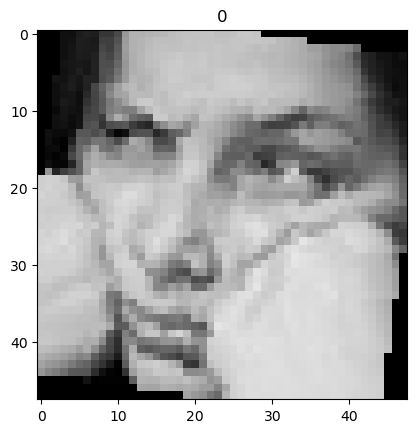

In [11]:
image , label = trainset[10]
print(image.shape)
plt.imshow(image.permute(1,2,0)) #(c,h,w)->(h,w,c)c at 0,h at 1 and w at 2
plt.title(label)


In [12]:
print(trainset.class_to_idx)


{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '3')

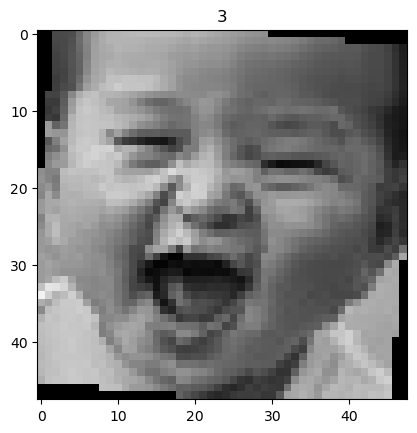

In [13]:
image , label = trainset[10000]
plt.imshow(image.permute(1,2,0)) #(c,h,w)->(h,w,c)c at 0,h at 1 and w at 2
plt.title(label)


Text(0.5, 1.0, '2')

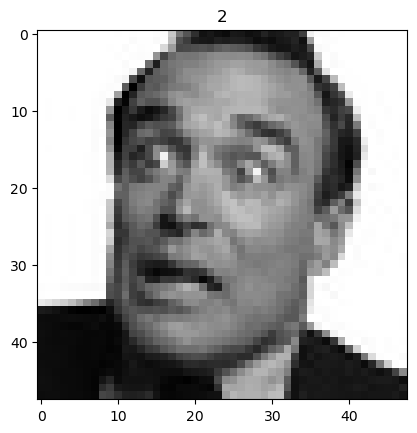

In [14]:
image , label = validset[2000]
plt.imshow(image.permute(1,2,0)) #(c,h,w)->(h,w,c)c at 0,h at 1 and w at 2
plt.title(label)


In [15]:
print(validset.class_to_idx)


{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [16]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset,batch_size=BATCH_SIZE)


In [17]:
len(validloader)


221

In [18]:
for images,labels in trainloader:
    break;
print(f"one images of batch shape {images.shape}") #[32 -> batch size, 3->labels , 48->height,48 -> width]
print(f"one label batch shape {labels.shape}")


one images of batch shape torch.Size([32, 3, 48, 48])
one label batch shape torch.Size([32])


**Create RestNet Model**

In [19]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel,self).__init__()
        self.eff_net = timm.create_model('resnet34', pretrained = True, num_classes = 7)
    def forward(self,images,labels = None):
        logits = self.eff_net(images)
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits,labels)
            return logits,loss
        return logits


In [20]:
resnet_model = ResNetModel()

resnet_model.to(DEVICE)


ResNetModel(
  (eff_net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

**Define Train and Evaluate Functions**

In [21]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


In [22]:
def train_fn(model,dataloader,optimizer,current_epo):
    model.train()
    total_loss = 0.0
    total_acc = 0.0 
    tk = tqdm(dataloader,desc = "EPOCHS" + "[TRAIN]" + str(current_epo+1) + "/"+ str(EPOCHS))
    for t,data in enumerate(tk):
        images,labels = data
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits,loss = model(images,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits,labels)
        tk.set_postfix({'loss':'%6f' %float(total_loss/(t+1)),'acc':'%6f' %float(total_acc/(t+1))})
    return total_loss/len(dataloader),total_acc/len(dataloader)


In [23]:
def eval_fn(model,dataloader,current_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0 
    tk = tqdm(dataloader,desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + "/"+ str(EPOCHS))
    for t,data in enumerate(tk):
        images,labels = data
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        
        
        logits,loss = model(images,labels)
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits,labels)
        tk.set_postfix({'loss':'%6f' %float(total_loss/(t+1)),'acc':'%6f' %float(total_acc/(t+1))})
    return total_loss/len(dataloader),total_acc/len(dataloader)


**Train Model**

In [24]:
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=LR)


In [25]:
best_valid_losses = {'resnet': np.inf, 'inception': np.inf, 'vgg': np.inf}

for epoch in range(EPOCHS):
    resnet_train_loss, resnet_train_acc = train_fn(resnet_model, trainloader, resnet_optimizer, epoch)
     
    resnet_eval_loss, resnet_eval_acc = eval_fn(resnet_model, validloader, epoch)
    
    
    # Print progress
    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'ResNet Train Loss: {resnet_train_loss:.4f}, Train Acc: {resnet_train_acc:.4f}, '
          f'ResNet Valid Loss: {resnet_eval_loss:.4f}, Valid Acc: {resnet_eval_acc:.4f}')
    
    # Check for improvement in validation losses for each model
    if resnet_eval_loss < best_valid_losses['resnet']:
        torch.save(resnet_model.state_dict(), 'best-resnet-weights.pt')
        print("Saved Best ResNet Valid Loss")
        best_valid_losses['resnet'] = resnet_eval_loss


EPOCH[VALID]1/30: 100%|██████████| 221/221 [00:03<00:00, 61.23it/s, loss=1.223272, acc=0.531489]


Epoch [1/30], ResNet Train Loss: 1.4916, Train Acc: 0.4181, ResNet Valid Loss: 1.2233, Valid Acc: 0.5315
Saved Best ResNet Valid Loss


EPOCH[VALID]2/30: 100%|██████████| 221/221 [00:05<00:00, 41.70it/s, loss=1.133569, acc=0.571147]


Epoch [2/30], ResNet Train Loss: 1.2377, Train Acc: 0.5274, ResNet Valid Loss: 1.1336, Valid Acc: 0.5711
Saved Best ResNet Valid Loss


EPOCH[VALID]3/30: 100%|██████████| 221/221 [00:06<00:00, 33.17it/s, loss=1.100637, acc=0.576629]


Epoch [3/30], ResNet Train Loss: 1.1591, Train Acc: 0.5572, ResNet Valid Loss: 1.1006, Valid Acc: 0.5766
Saved Best ResNet Valid Loss


EPOCH[VALID]4/30: 100%|██████████| 221/221 [00:05<00:00, 37.18it/s, loss=1.050667, acc=0.609750]


Epoch [4/30], ResNet Train Loss: 1.0972, Train Acc: 0.5855, ResNet Valid Loss: 1.0507, Valid Acc: 0.6098
Saved Best ResNet Valid Loss


EPOCH[VALID]5/30: 100%|██████████| 221/221 [00:06<00:00, 31.96it/s, loss=1.041309, acc=0.611915]


Epoch [5/30], ResNet Train Loss: 1.0505, Train Acc: 0.6068, ResNet Valid Loss: 1.0413, Valid Acc: 0.6119
Saved Best ResNet Valid Loss


EPOCH[VALID]6/30: 100%|██████████| 221/221 [00:07<00:00, 30.53it/s, loss=1.047851, acc=0.610566]


Epoch [6/30], ResNet Train Loss: 1.0185, Train Acc: 0.6160, ResNet Valid Loss: 1.0479, Valid Acc: 0.6106


EPOCH[VALID]7/30: 100%|██████████| 221/221 [00:10<00:00, 21.18it/s, loss=1.036396, acc=0.618300]


Epoch [7/30], ResNet Train Loss: 0.9791, Train Acc: 0.6314, ResNet Valid Loss: 1.0364, Valid Acc: 0.6183
Saved Best ResNet Valid Loss


EPOCH[VALID]8/30: 100%|██████████| 221/221 [00:11<00:00, 19.04it/s, loss=1.056028, acc=0.611447]


Epoch [8/30], ResNet Train Loss: 0.9470, Train Acc: 0.6450, ResNet Valid Loss: 1.0560, Valid Acc: 0.6114


EPOCH[VALID]9/30: 100%|██████████| 221/221 [00:11<00:00, 18.93it/s, loss=1.025484, acc=0.626642]


Epoch [9/30], ResNet Train Loss: 0.9085, Train Acc: 0.6595, ResNet Valid Loss: 1.0255, Valid Acc: 0.6266
Saved Best ResNet Valid Loss


EPOCH[VALID]10/30: 100%|██████████| 221/221 [00:13<00:00, 16.98it/s, loss=0.995167, acc=0.635834]


Epoch [10/30], ResNet Train Loss: 0.8815, Train Acc: 0.6696, ResNet Valid Loss: 0.9952, Valid Acc: 0.6358
Saved Best ResNet Valid Loss


EPOCH[VALID]11/30: 100%|██████████| 221/221 [00:11<00:00, 19.37it/s, loss=1.052076, acc=0.610849]


Epoch [11/30], ResNet Train Loss: 0.8459, Train Acc: 0.6807, ResNet Valid Loss: 1.0521, Valid Acc: 0.6108


EPOCH[VALID]12/30: 100%|██████████| 221/221 [00:20<00:00, 10.76it/s, loss=0.969484, acc=0.647679]


Epoch [12/30], ResNet Train Loss: 0.8182, Train Acc: 0.6954, ResNet Valid Loss: 0.9695, Valid Acc: 0.6477
Saved Best ResNet Valid Loss


EPOCH[VALID]13/30: 100%|██████████| 221/221 [00:07<00:00, 30.45it/s, loss=1.029214, acc=0.634354]


Epoch [13/30], ResNet Train Loss: 0.7816, Train Acc: 0.7063, ResNet Valid Loss: 1.0292, Valid Acc: 0.6344


EPOCH[VALID]14/30: 100%|██████████| 221/221 [00:08<00:00, 26.29it/s, loss=1.029421, acc=0.646058]


Epoch [14/30], ResNet Train Loss: 0.7575, Train Acc: 0.7179, ResNet Valid Loss: 1.0294, Valid Acc: 0.6461


EPOCH[VALID]15/30: 100%|██████████| 221/221 [00:09<00:00, 23.26it/s, loss=1.029547, acc=0.653618]


Epoch [15/30], ResNet Train Loss: 0.7236, Train Acc: 0.7308, ResNet Valid Loss: 1.0295, Valid Acc: 0.6536


EPOCH[VALID]16/30: 100%|██████████| 221/221 [00:13<00:00, 15.82it/s, loss=1.044354, acc=0.639978]


Epoch [16/30], ResNet Train Loss: 0.6881, Train Acc: 0.7445, ResNet Valid Loss: 1.0444, Valid Acc: 0.6400


EPOCH[VALID]17/30: 100%|██████████| 221/221 [00:12<00:00, 18.41it/s, loss=1.061971, acc=0.647320]


Epoch [17/30], ResNet Train Loss: 0.6587, Train Acc: 0.7544, ResNet Valid Loss: 1.0620, Valid Acc: 0.6473


EPOCH[VALID]18/30: 100%|██████████| 221/221 [00:12<00:00, 17.19it/s, loss=1.113230, acc=0.640576]


Epoch [18/30], ResNet Train Loss: 0.6228, Train Acc: 0.7692, ResNet Valid Loss: 1.1132, Valid Acc: 0.6406


EPOCH[VALID]19/30: 100%|██████████| 221/221 [00:13<00:00, 16.64it/s, loss=1.096086, acc=0.646896]


Epoch [19/30], ResNet Train Loss: 0.5912, Train Acc: 0.7839, ResNet Valid Loss: 1.0961, Valid Acc: 0.6469


EPOCH[VALID]20/30: 100%|██████████| 221/221 [00:05<00:00, 39.25it/s, loss=1.156283, acc=0.648179]


Epoch [20/30], ResNet Train Loss: 0.5706, Train Acc: 0.7904, ResNet Valid Loss: 1.1563, Valid Acc: 0.6482


EPOCH[VALID]21/30: 100%|██████████| 221/221 [00:08<00:00, 24.86it/s, loss=1.204724, acc=0.636323]


Epoch [21/30], ResNet Train Loss: 0.5398, Train Acc: 0.8021, ResNet Valid Loss: 1.2047, Valid Acc: 0.6363


EPOCH[VALID]22/30: 100%|██████████| 221/221 [00:10<00:00, 21.07it/s, loss=1.135780, acc=0.646025]


Epoch [22/30], ResNet Train Loss: 0.5108, Train Acc: 0.8126, ResNet Valid Loss: 1.1358, Valid Acc: 0.6460


EPOCH[VALID]23/30: 100%|██████████| 221/221 [00:12<00:00, 18.24it/s, loss=1.180930, acc=0.643687]


Epoch [23/30], ResNet Train Loss: 0.4889, Train Acc: 0.8208, ResNet Valid Loss: 1.1809, Valid Acc: 0.6437


EPOCH[VALID]24/30: 100%|██████████| 221/221 [00:14<00:00, 14.76it/s, loss=1.255316, acc=0.639303]


Epoch [24/30], ResNet Train Loss: 0.4646, Train Acc: 0.8299, ResNet Valid Loss: 1.2553, Valid Acc: 0.6393


EPOCH[VALID]25/30: 100%|██████████| 221/221 [00:09<00:00, 23.56it/s, loss=1.381230, acc=0.608336]


Epoch [25/30], ResNet Train Loss: 0.4453, Train Acc: 0.8353, ResNet Valid Loss: 1.3812, Valid Acc: 0.6083


EPOCH[VALID]26/30: 100%|██████████| 221/221 [00:05<00:00, 40.70it/s, loss=1.282250, acc=0.650072]


Epoch [26/30], ResNet Train Loss: 0.4191, Train Acc: 0.8446, ResNet Valid Loss: 1.2823, Valid Acc: 0.6501


EPOCH[VALID]27/30: 100%|██████████| 221/221 [00:06<00:00, 36.46it/s, loss=1.338458, acc=0.640565]


Epoch [27/30], ResNet Train Loss: 0.4025, Train Acc: 0.8551, ResNet Valid Loss: 1.3385, Valid Acc: 0.6406


EPOCH[VALID]28/30: 100%|██████████| 221/221 [00:05<00:00, 40.73it/s, loss=1.343825, acc=0.644840]


Epoch [28/30], ResNet Train Loss: 0.3775, Train Acc: 0.8633, ResNet Valid Loss: 1.3438, Valid Acc: 0.6448


EPOCH[VALID]29/30: 100%|██████████| 221/221 [00:09<00:00, 24.50it/s, loss=1.406351, acc=0.646580]


Epoch [29/30], ResNet Train Loss: 0.3583, Train Acc: 0.8714, ResNet Valid Loss: 1.4064, Valid Acc: 0.6466


EPOCH[VALID]30/30: 100%|██████████| 221/221 [00:08<00:00, 27.13it/s, loss=1.379844, acc=0.645514]

Epoch [30/30], ResNet Train Loss: 0.3458, Train Acc: 0.8741, ResNet Valid Loss: 1.3798, Valid Acc: 0.6455


**Evaluate Results**

In [26]:
best_valid_losses['resnet']


0.9694841098866311

In [27]:
resnet_eval_acc*100


tensor(64.5514)